In [1]:

import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torchvision.transforms import ToTensor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image

# -----------------------------
# 1. CONFIGURATION
# -----------------------------
# Paths—adjust these to your setup
GLYPH_CLASSES_DIR = "/home/default/AI-project/glyph_images"         # Directory containing one image per glyph class
TRAIN_IMAGES_DIR  = "/home/default/AI-project/yolo_dataset/images/train"
TRAIN_LABELS_DIR  = "/home/default/AI-project/yolo_dataset/labels/train"

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 0.005
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

In [2]:
# -----------------------------
# 2. COUNT GLYPH CLASSES
# -----------------------------
# We assume each file in GLYPH_CLASSES_DIR represents one glyph class.
glyph_filenames = [
    f
    for f in os.listdir(GLYPH_CLASSES_DIR)
    if os.path.isfile(os.path.join(GLYPH_CLASSES_DIR, f))
]
num_glyph_classes = len(glyph_filenames)
# Faster R-CNN needs num_classes = (# of real classes) + 1 (background)
num_classes = num_glyph_classes + 1
print(f"Detected {num_glyph_classes} glyph classes → setting num_classes = {num_classes} (including background)")


Detected 922 glyph classes → setting num_classes = 923 (including background)


In [3]:
# -----------------------------
# 3. YOLO-STYLE DATASET CLASS
# -----------------------------
class YoloFolderDataset(Dataset):
    """
    Expects:
      - images_dir: directory of images (e.g. jpg/png)
      - labels_dir: directory of YOLO-format .txt labels
        Each label file should have lines: <class_id> <x_center> <y_center> <width> <height>
        where all coords are normalized [0,1] relative to image size.
      - num_classes is inferred above, but label files should use class_id ∈ [0 .. num_glyph_classes-1].
      - We convert YOLO boxes to [xmin, ymin, xmax, ymax] in absolute pixel coords,
        and shift class_id by +1 (because 0 = background for Faster R-CNN).
    """
    def __init__(self, images_dir, labels_dir, transforms=None, valid_image_exts=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms

        if valid_image_exts is None:
            valid_image_exts = [".jpg", ".jpeg", ".png", ".bmp"]
        self.valid_image_exts = valid_image_exts

        # Gather all image filenames with a valid extension
        self.image_files = [
            fname
            for fname in os.listdir(images_dir)
            if os.path.splitext(fname)[1].lower() in self.valid_image_exts
        ]
        if len(self.image_files) == 0:
            raise RuntimeError(f"No images found in {images_dir} with extensions {valid_image_exts}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # 1) Load image
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_filename)
        img = Image.open(image_path).convert("RGB")
        width, height = img.size

        # 2) Load corresponding YOLO label file (same name, .txt)
        label_filename = os.path.splitext(image_filename)[0] + ".txt"
        label_path = os.path.join(self.labels_dir, label_filename)

        boxes = []
        labels = []

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue  # skip malformed lines
                    class_id, x_c, y_c, w, h = map(float, parts)
                    # Convert from YOLO (relative) to absolute VOC:
                    xmin = (x_c - w / 2) * width
                    xmax = (x_c + w / 2) * width
                    ymin = (y_c - h / 2) * height
                    ymax = (y_c + h / 2) * height
                    boxes.append([xmin, ymin, xmax, ymax])
                    # Shift class_id by +1: 0 → background, so real classes are 1..num_glyph_classes
                    labels.append(int(class_id) + 1)

        # If no label file exists or is empty, we still return an empty target
        if len(boxes) == 0:
            # No objects → create an empty tensor for boxes/labels
            boxes_tensor = torch.zeros((0, 4), dtype=torch.float32)
            labels_tensor = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
            labels_tensor = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes_tensor,
            "labels": labels_tensor,
            "image_id": torch.tensor([idx]),
        }

        # Apply transforms (e.g. ToTensor) to image
        if self.transforms:
            img = self.transforms(img)

        return img, target


In [4]:
# -----------------------------
# 4. MODEL SETUP
# -----------------------------
def get_faster_rcnn_model(num_classes):
    # Load a pre-trained Faster R-CNN with ResNet-50 + FPN backbone
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Replace the box predictor head with one that has `num_classes` outputs
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [5]:
# 5. DATA LOADER & TRAINING LOOP
# -----------------------------
def collate_fn(batch):
    # batch is a list of (image, target) tuples
    return tuple(zip(*batch))

def train():
    # 5.1 Instantiate dataset and dataloader
    dataset = YoloFolderDataset(
        images_dir=TRAIN_IMAGES_DIR,
        labels_dir=TRAIN_LABELS_DIR,
        transforms=ToTensor()
    )
    data_loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        collate_fn=collate_fn
    )

    # 5.2 Create model and move to device
    model = get_faster_rcnn_model(num_classes)
    model.to(DEVICE)

    # 5.3 Construct optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params,
        lr=LEARNING_RATE,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY
    )

    # 5.4 Training loop
    model.train()
    for epoch in range(NUM_EPOCHS):
        epoch_loss = 0.0
        for images, targets in data_loader:
            # Move data to DEVICE
            images = [img.to(DEVICE) for img in images]
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            # Forward pass (returns a dict of losses)
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            epoch_loss += loss_value

            # Backprop + optimizer step
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        avg_epoch_loss = epoch_loss / len(data_loader)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]  -  Loss: {avg_epoch_loss:.4f}")

    # 5.5 Save checkpoint
    checkpoint_path = "fasterrcnn_glyphs_checkpoint.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Training complete. Model saved to '{checkpoint_path}'.")

In [6]:
# 6. RUN TRAINING
# -----------------------------
if __name__ == "__main__":
    train()


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20]  -  Loss: 2.6203
Epoch [2/20]  -  Loss: 1.8413
Epoch [3/20]  -  Loss: 1.3177
Epoch [4/20]  -  Loss: 0.8367
Epoch [5/20]  -  Loss: 0.5407
Epoch [6/20]  -  Loss: 0.3919
Epoch [7/20]  -  Loss: 0.3075
Epoch [8/20]  -  Loss: 0.2543
Epoch [9/20]  -  Loss: 0.2215
Epoch [10/20]  -  Loss: 0.1969
Epoch [11/20]  -  Loss: 0.1789
Epoch [12/20]  -  Loss: 0.1649
Epoch [13/20]  -  Loss: 0.1545
Epoch [14/20]  -  Loss: 0.1456
Epoch [15/20]  -  Loss: 0.1369
Epoch [16/20]  -  Loss: 0.1311
Epoch [17/20]  -  Loss: 0.1251
Epoch [18/20]  -  Loss: 0.1201
Epoch [19/20]  -  Loss: 0.1162
Epoch [20/20]  -  Loss: 0.1138
Training complete. Model saved to 'fasterrcnn_glyphs_checkpoint.pth'.


Found 922 glyph classes → using num_classes = 923 (including background)
Detections:
  • Label: 773, Score: 0.783, Box: [38.9, 751.7, 145.2, 895.0]
  • Label: 415, Score: 0.732, Box: [51.1, 95.4, 127.2, 223.9]
  • Label: 50, Score: 0.724, Box: [102.4, 404.4, 193.6, 490.1]
  • Label: 544, Score: 0.592, Box: [116.2, 426.3, 211.6, 615.7]
  • Label: 702, Score: 0.492, Box: [93.8, 779.2, 192.8, 873.4]
  • Label: 1, Score: 0.477, Box: [226.7, 89.0, 242.1, 115.7]
  • Label: 773, Score: 0.411, Box: [48.1, 453.7, 118.7, 615.6]
  • Label: 154, Score: 0.363, Box: [117.9, 29.6, 161.1, 49.4]
  • Label: 80, Score: 0.360, Box: [115.8, 786.8, 191.6, 870.2]
  • Label: 50, Score: 0.315, Box: [123.6, 281.9, 208.6, 401.3]
  • Label: 544, Score: 0.314, Box: [131.9, 267.4, 208.6, 409.4]
  • Label: 918, Score: 0.289, Box: [15.4, 535.6, 37.6, 551.2]
  • Label: 262, Score: 0.246, Box: [41.4, 243.4, 96.9, 403.8]
  • Label: 579, Score: 0.233, Box: [121.8, 27.9, 157.9, 51.9]
  • Label: 544, Score: 0.203, Box: [93

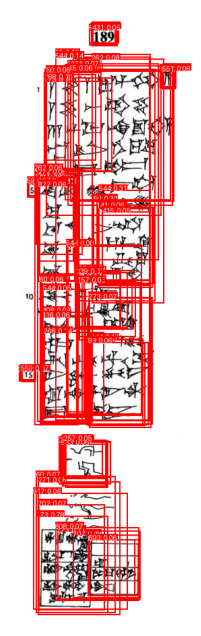

In [ ]:
import os
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# -----------------------------
# 1. CONFIGURATION
# -----------------------------
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Folder containing one file per glyph class (used during training)
GLYPH_CLASSES_DIR = "/home/default/AI-project/glyph_images"

# Path to the trained checkpoint (from training script)
CHECKPOINT_PATH = "fasterrcnn_glyphs_checkpoint.pth"

# Path to the image you want to test
IMAGE_PATH = "image (1).jpg"

# Minimum confidence for showing detections
CONFIDENCE_THRESHOLD = 0.01

# -----------------------------
# 2. COUNT CLASSES (MATCH TRAINING)
# -----------------------------
glyph_filenames = [
    f for f in os.listdir(GLYPH_CLASSES_DIR)
    if os.path.isfile(os.path.join(GLYPH_CLASSES_DIR, f))
]
num_glyph_classes = len(glyph_filenames)
if num_glyph_classes == 0:
    raise RuntimeError(f"No files found in {GLYPH_CLASSES_DIR}; cannot infer num_glyph_classes.")
# Faster R-CNN expects num_classes = (# real classes) + 1 (for background)
num_classes = num_glyph_classes + 1
print(f"Found {num_glyph_classes} glyph classes → using num_classes = {num_classes} (including background)")

# -----------------------------
# 3. HELPER: LOAD TRAINED MODEL
# -----------------------------
def load_trained_faster_rcnn(num_classes, checkpoint_path, device):
    # Create the same architecture used in training
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Load the weights
    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model

# -----------------------------
# 4. INFERENCE FUNCTION
# -----------------------------
def run_inference_on_image(model, image_path, device, threshold=0.5):
    # Load PIL image
    img = Image.open(image_path).convert("RGB")

    # Preprocess to tensor
    img_tensor = F.to_tensor(img).to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model([img_tensor])[0]

    # Extract boxes, labels, scores
    boxes = outputs["boxes"].cpu()
    labels = outputs["labels"].cpu()
    scores = outputs["scores"].cpu()

    # Filter by threshold
    keep = torch.where(scores >= threshold)[0]
    return {
        "boxes": boxes[keep],
        "labels": labels[keep],
        "scores": scores[keep],
        "orig_image": img
    }

# -----------------------------
# 5. DRAW DETECTIONS (WITH THRESHOLD)
# -----------------------------
def draw_detections(inference_result, threshold=0.5):
    img = inference_result["orig_image"].copy()
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.load_default()
    except:
        font = None

    for box, label, score in zip(
        inference_result["boxes"],
        inference_result["labels"],
        inference_result["scores"]
    ):
        if score < threshold:
            continue  # Skip low-confidence detections

        xmin, ymin, xmax, ymax = box.tolist()
        # Draw bounding box
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)

        # Annotate with label and score
        text = f"{int(label.item())}: {score:.2f}"
        if font:
            bbox = font.getbbox(text)
            text_size = (bbox[2] - bbox[0], bbox[3] - bbox[1])
        else:
            # approximate size if no font
            text_size = (len(text) * 6, 10)

        text_bg = [xmin, ymin - text_size[1], xmin + text_size[0], ymin]
        draw.rectangle(text_bg, fill="red")
        draw.text((xmin, ymin - text_size[1]), text, fill="white", font=font)

    return img

# -----------------------------
# 6. RUN INFERENCE AND DISPLAY
# -----------------------------
if __name__ == "__main__":
    # Load the trained model (ensure num_classes matches training)
    model = load_trained_faster_rcnn(num_classes, CHECKPOINT_PATH, DEVICE)

    # Run inference with filtering
    result = run_inference_on_image(model, IMAGE_PATH, DEVICE, threshold=CONFIDENCE_THRESHOLD)

    # Print out detections
    print("Detections:")
    for box, label, score in zip(result["boxes"], result["labels"], result["scores"]):
        xmin, ymin, xmax, ymax = box.tolist()
        print(f"  • Label: {int(label.item())}, Score: {score:.3f}, Box: [{xmin:.1f}, {ymin:.1f}, {xmax:.1f}, {ymax:.1f}]")

    # Draw and show only high-confidence detections
    img_with_boxes = draw_detections(result, threshold=CONFIDENCE_THRESHOLD)
    plt.figure(figsize=(8, 8))
    plt.imshow(img_with_boxes)
    plt.axis("off")
    plt.show()


In [ ]:
!pip install torch torchvision pillow matplotlib
